In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Show original image

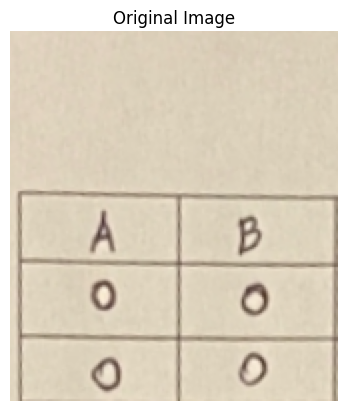

In [4]:
image = cv2.imread("../img/test4.png")
height, width = image.shape[:2]
cv2.namedWindow("Original Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Original Image", width, height)
cv2.imshow("Original Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
show_images([image],["Original Image"])

## Binary Thresholding

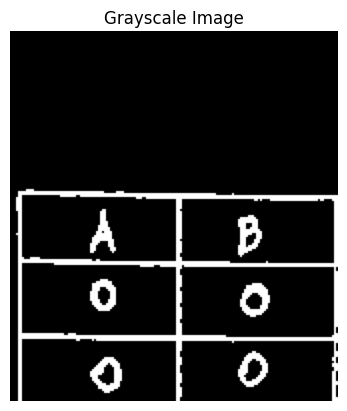

In [5]:
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh_img = cv2.adaptiveThreshold(grayscale_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,75,15)
cv2.namedWindow("Grayscale Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Grayscale Image", width, height)
cv2.imshow("Grayscale Image", thresh_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
show_images([thresh_img],["Grayscale Image"])

## Morphological Operations

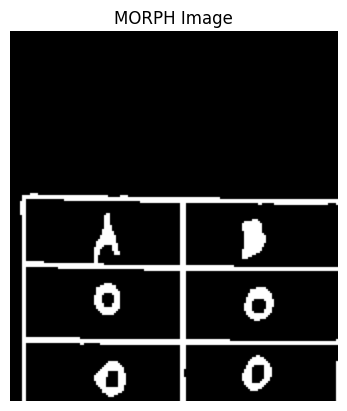

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

cv2.namedWindow("MORPH Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("MORPH Image", width, height)
cv2.imshow("MORPH Image", closing)
cv2.waitKey(0)
cv2.destroyAllWindows()
show_images([closing],["MORPH Image"])

## Remove Vertical and Horizontal Lines

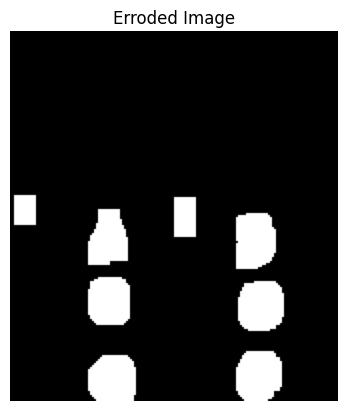

In [7]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 6))
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
eroded_image_v = cv2.erode(closing, vertical_kernel, iterations=5)
eroded_image_h = cv2.erode(closing, horizontal_kernel, iterations=4)
subtracted_image = cv2.subtract(closing, eroded_image_h)
subtracted_image = cv2.subtract(subtracted_image, eroded_image_v)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
subtracted_image = cv2.morphologyEx(subtracted_image, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
subtracted_image = cv2.morphologyEx(subtracted_image, cv2.MORPH_CLOSE, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
subtracted_image = cv2.morphologyEx(subtracted_image, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
subtracted_image = cv2.morphologyEx(subtracted_image, cv2.MORPH_CLOSE, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
subtracted_image=cv2.dilate(subtracted_image,kernel,iterations=2)
cv2.namedWindow("Erroded Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Erroded Image", width, height)
cv2.imshow("Erroded Image", subtracted_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
show_images([subtracted_image],["Erroded Image"])


## Draw Contours

In [8]:
# CHAIN_APPROX_SIMPLE to only store the necessary points of the contour
# RETR_EXTERNAL to only detect the outer contours
contours, hierarchy = cv2.findContours(subtracted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(contours)
cv2.drawContours(grayscale_image, contours, -1, (0,255,0), 3)



array([[207, 208, 208, ..., 200, 203, 204],
       [205, 207, 208, ..., 201, 201, 201],
       [204, 206, 208, ..., 202, 201, 201],
       ...,
       [206, 208, 212, ..., 163, 130, 169],
       [208, 210, 211, ..., 165, 135, 163],
       [208, 210, 211, ..., 164, 135, 157]], dtype=uint8)

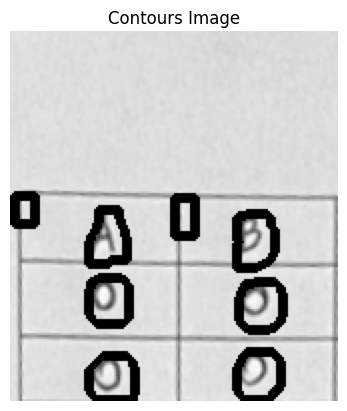

In [9]:
cv2.namedWindow("Contours Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Contours Image", width, height)
cv2.imshow("Contours Image", grayscale_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
show_images([grayscale_image],["Contours Image"])

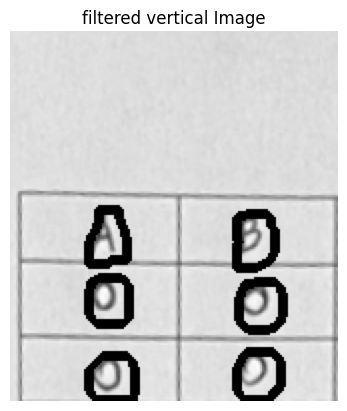

In [10]:
boxes_h = np.array([cv2.boundingRect(c) for c in contours])
#! These first two columns typically represent the top-left corner coordinates of the bounding boxes (x and y).
#! The last two columns represent the width and height of the bounding box, respectively.
#! calculate the center of the bounding boxes
centers_h = boxes_h[:, :2] + boxes_h[:, 2:] / 2
#! convert centres to a column vector with either x or y distances then generate a matrix of distances from each centre of #rows = #centres and #cols = #centres
#! remove contours with no neighbours vertically
horizontal_distances = np.abs(centers_h[:, 0][:, np.newaxis] - centers_h[:, 0])
horizontal_distances[horizontal_distances <= 15] = 0
horizontal_distances[np.arange(horizontal_distances.shape[0])[:, np.newaxis] == np.arange(horizontal_distances.shape[1])] = 1000000
#! count the number of neighbor contours vertically
num_zero_indices_h = np.sum(horizontal_distances == 0, axis=1)
indices_to_remove_h = np.where(num_zero_indices_h < np.ceil(np.mean(num_zero_indices_h)))

if (len(num_zero_indices_h) > 100):
   indices_to_remove_h = np.where(num_zero_indices_h < 4)

mask_h = np.ones(len(contours), dtype=bool)
mask_h[indices_to_remove_h[0]] = False
filtered_contours = [np.array(contour) for i, contour in enumerate(contours) if i not in indices_to_remove_h[0]]

grayscale_image2 = cv2.cvtColor(cv2.imread("../img/test4.png"), cv2.COLOR_BGR2GRAY)

cv2.drawContours(grayscale_image2, filtered_contours, -1, (0,255,0), 3)
cv2.namedWindow("filtered vertical Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("filtered vertical Image", width, height)
cv2.imshow("filtered vertical Image", grayscale_image2)
cv2.waitKey(0)
cv2.destroyAllWindows()
show_images([grayscale_image2],["filtered vertical Image"])


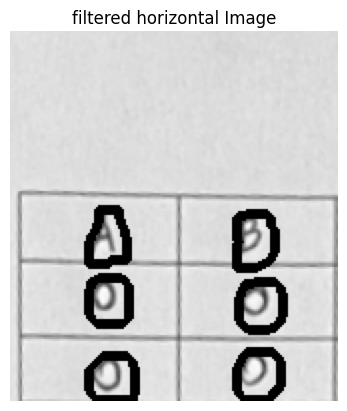

In [11]:

#! remove contours with no neighbours horizontally
boxes_y = np.array([cv2.boundingRect(c) for c in filtered_contours])
centers_y = boxes_y[:, :2] + boxes_y[:, 2:] / 2

vertical_distances = np.abs(centers_y[:, 1][:, np.newaxis] - centers_y[:, 1]) 
vertical_distances[vertical_distances <= 15] = 0
vertical_distances[np.arange(vertical_distances.shape[0])[:, np.newaxis] == np.arange(vertical_distances.shape[1])] = 1000000
#! count the number of neighbor contours horizontally
num_zero_indices_y = np.sum(vertical_distances == 0, axis=1)
indices_to_remove_y = np.where(num_zero_indices_y < np.ceil(np.mean(num_zero_indices_y)))
if (len(num_zero_indices_y) > 100):
    indices_to_remove_y = np.where(num_zero_indices_y < 4)
mask_v = np.ones(len(contours), dtype=bool)
mask_v[indices_to_remove_y[0]] = False
filtered_contours = [np.array(contour) for i, contour in enumerate(filtered_contours) if i not in indices_to_remove_y[0]]

grayscale_image3 = cv2.cvtColor(cv2.imread("../img/test4.png"), cv2.COLOR_BGR2GRAY)

cv2.drawContours(grayscale_image3, filtered_contours, -1, (0,255,0), 3)
cv2.namedWindow("filtered horizontal Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("filtered horizontal Image", width, height)
cv2.imshow("filtered horizontal Image", grayscale_image3)
cv2.waitKey(0)
cv2.destroyAllWindows()
show_images([grayscale_image3],["filtered horizontal Image"])

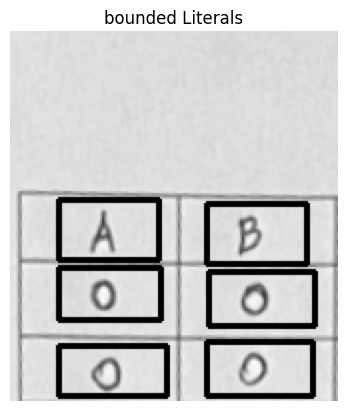

In [12]:
grayscale_image4 = cv2.cvtColor(cv2.imread("../img/test4.png"), cv2.COLOR_BGR2GRAY)

rectangles = np.array([cv2.boundingRect(c) for c in filtered_contours])
x_offset=15
y_offset=2
for rect in rectangles:
    x, y, w, h = rect
    cv2.rectangle(grayscale_image4, (x-x_offset, y-y_offset-3), (x +x_offset +w, y + h+ y_offset -5), (0, 255, 0), 2)


cv2.namedWindow("bounded Literals", cv2.WINDOW_NORMAL)
cv2.resizeWindow("bounded Literals", width, height)
cv2.imshow("bounded Literals", grayscale_image4)
cv2.waitKey(0)
cv2.destroyAllWindows()
show_images([grayscale_image4],["bounded Literals"])

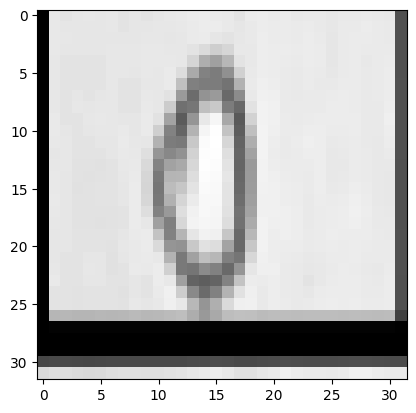

In [13]:
x, y, w, h = rectangles[0]

extracted_rectangle = grayscale_image4[y-y_offset:y+h+y_offset, x-x_offset:x+w+x_offset]
resized_rectangle = cv2.resize(extracted_rectangle, (32, 32))

cv2.namedWindow("bounded Literals", cv2.WINDOW_NORMAL)
cv2.resizeWindow("bounded Literals", 32, 32)
cv2.imshow("bounded Literals", extracted_rectangle)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(resized_rectangle)
#show_images([extracted_rectangle],["bounded Literals"])